# Movies Recommender System
   Recommender systems are one of the most successful and widespread application of machine learning technologies in business. 
    
# Heroku App
   Applink : https://mov-rec-syst.herokuapp.com/

# Problem Statement

   + Identify movies that customers want to watch, as demonstrated by their post - viewing rating
   + Identify a list of movie recommendations, which contains at least one that theuser 
     will start watching as their next selection

# Dataset : Movielens
   https://grouplens.org/datasets/movielens/100k
   
   #### Files contained in the project
   + movies.csv : movies data from MovieLens dataset
   + ratings.csv : rating given by user to movie from MovieLens dataset

# Repository Structure
   https://github.com/gdharanidharan/Movie_Recommender_System

   + MOVIE_RECOMMENDATION_SYSTEM.ipynb: The Jupyter notebook containing code for the recommendation engines
   + Data should be put in data folder
   + app.py : Flask App 
   + requirements.txt
   + config files
   + Docker
   + Pickle files

# Types of recommendation engines

   + Simple Recommender:         Simple recommenders offer generalized recommendations to every user, based on movie 
                               popularity and/or genre. The basic idea behind this system is that movies that are 
                               more popular and critically acclaimed will have a higher probability of being liked
                               by the average audience. An example could be IMDB Top 250

   + Content Based Recommender:  Content-based recommenders: suggest similar items based on a particular item. 
                               This system uses item metadata, such as genre, director, description, actors, etc. 
                               for movies, to make these recommendations. The general idea behind these recommender 
                               systems is that if a person likes a particular item, he or she will also like an item 
                               that is similar to it. And to recommend that, it will make use of the user's past item
                               metadata. A good example could be YouTube, where based on your history, it suggests you
                               new videos that you could potentially watch

   + Collaborative Filtering:    These systems are widely used, and they try to predict the rating or preference that a 
                               user would give an item-based on past ratings and preferences of other users. 
                               Collaborative filters do not require item metadata like its content-based counterparts

# Approach

   The problem was divided into several steps:

   + Data Collection :  Data was collected from the MovieLens website

   + EDA :              Data visualisation and summary statistics were used to extract insights and pattern from the various datasets

   + Engine:            Recommending movies considering the post review ratings of users so I'm considering "Collaborative Filtering" technique for this problem statement
                       
   + GUI :              Flask App
    
   + Cloud :            Heroku

# Python libraries
   1. Pandas
   2. Matplotlib
   3. seaborn
   4. scikit-learn
   5. scipy
   6. Flask

# Index
- Loading Libraries
- Data Preparation
- Exploratory Data Analysis(EDA)
- Creating Similairty matrix
- Collaborative Filtering

## Load Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Data Preparation

In [2]:
# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId','title','genres'])

In [3]:
df_movies = movies 
df_ratings = ratings 

## Exploratory Data Analysis(EDA)

In [4]:
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Most popular genres of movie released

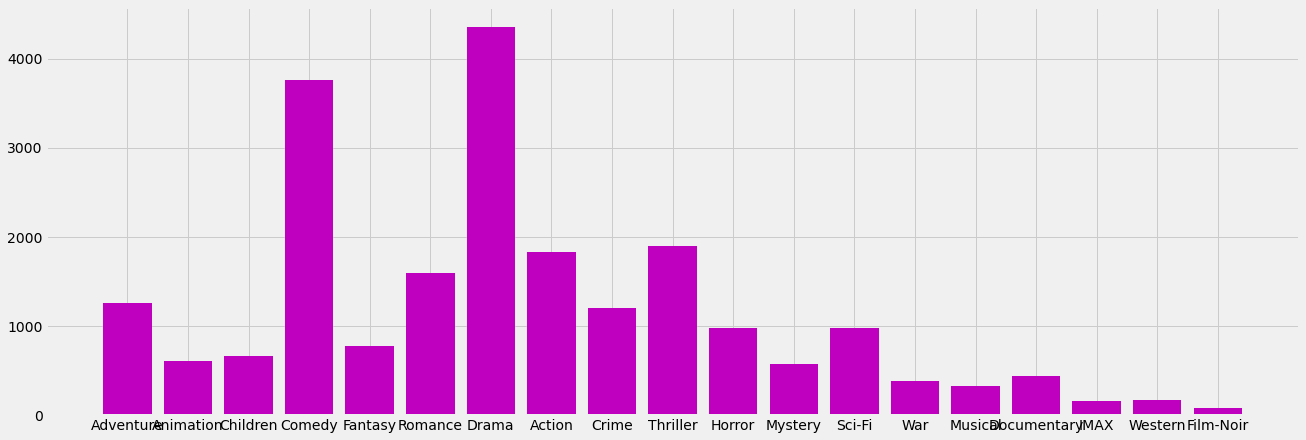

In [5]:
plt.figure(figsize=(20,7))
generlist = df_movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='m');

In [6]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Distribution of users rating

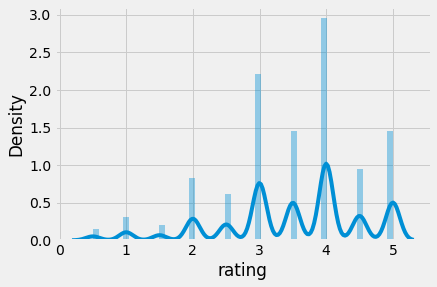

In [7]:
sns.distplot(df_ratings["rating"]);

In [8]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(df_ratings.shape)+"\n Movies DataFrame"+ str(df_movies.shape))

Shape of frames: 
 Rating DataFrame(100836, 4)
 Movies DataFrame(9742, 3)


### Merging both movies and ratings dataframe

In [9]:
df_movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [10]:
df_ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


 ''' 
 movieId is a common field for both the dataframe so merging on that
 '''

In [11]:
merge_ratings_movies = pd.merge(df_movies, df_ratings, on='movieId', how='inner')

In [12]:
merge_ratings_movies.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962


#### Dropping timestamp column

In [13]:
merge_ratings_movies = merge_ratings_movies.drop('timestamp', axis=1)

In [14]:
merge_ratings_movies.head(2)

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0


In [15]:
merge_ratings_movies.shape

(100836, 5)

### Grouping the rating based on user

In [16]:
ratings_grouped_by_users = merge_ratings_movies.groupby('userId').agg([np.size, np.mean])

In [17]:
ratings_grouped_by_users.head(5)

movieId               rating          
          size          mean   size      mean
userId                                       
1          232   1854.603448    232  4.366379
2           29  70350.275862     29  3.948276
3           39   7058.384615     39  2.435897
4          216   1982.129630    216  3.555556
5           44    343.840909     44  3.636364

In [18]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)
ratings_grouped_by_users

rating          
         size      mean
userId                 
1         232  4.366379
2          29  3.948276
3          39  2.435897
4         216  3.555556
5          44  3.636364
...       ...       ...
606      1115  3.657399
607       187  3.786096
608       831  3.134176
609        37  3.270270
610      1302  3.688556

[610 rows x 2 columns]

### Top 10 users who have rated most of the movies

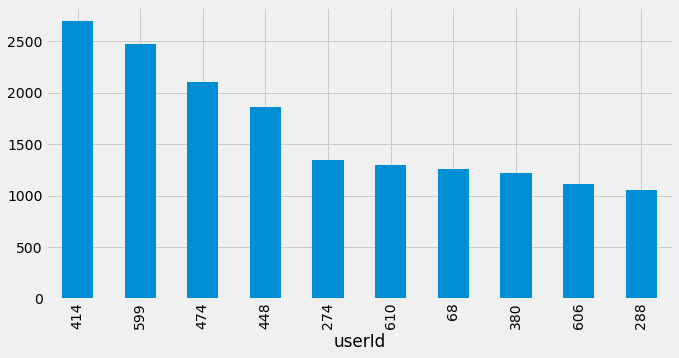

In [19]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind = 'bar', figsize = (10,5));

### Grouping the rating based on movies

In [20]:
merge_ratings_movies.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [21]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('title').agg([np.size, np.mean])

In [22]:
ratings_grouped_by_movies.shape

(9719, 6)

In [23]:
ratings_grouped_by_movies.head(5)

movieId           userId         \
                                           size      mean   size   mean   
title                                                                     
'71 (2014)                                    1  117867.0      1  610.0   
'Hellboy': The Seeds of Creation (2004)       1   97757.0      1  332.0   
'Round Midnight (1986)                        2   26564.0      2  354.5   
'Salem's Lot (2004)                           1   27751.0      1  345.0   
'Til There Was You (1997)                     2     779.0      2  229.0   

                                        rating       
                                          size mean  
title                                                
'71 (2014)                                   1  4.0  
'Hellboy': The Seeds of Creation (2004)      1  4.0  
'Round Midnight (1986)                       2  3.5  
'Salem's Lot (2004)                          1  5.0  
'Til There Was You (1997)                    2  4.0

In [24]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop(['userId','movieId'], axis=1)
ratings_grouped_by_movies.head(5)

rating     
                                          size mean
title                                              
'71 (2014)                                   1  4.0
'Hellboy': The Seeds of Creation (2004)      1  4.0
'Round Midnight (1986)                       2  3.5
'Salem's Lot (2004)                          1  5.0
'Til There Was You (1997)                    2  4.0

### Movies with high average rating

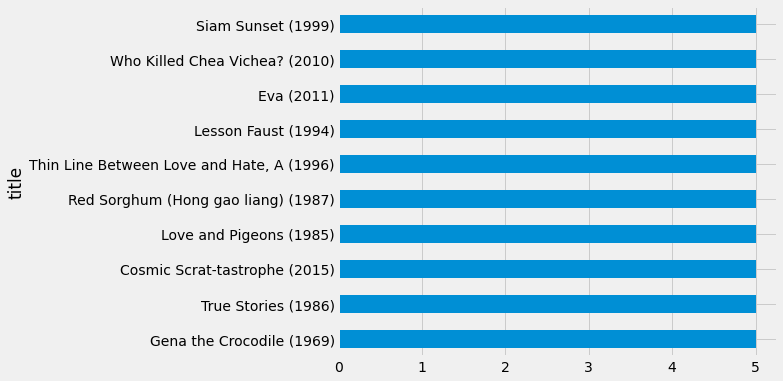

In [25]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6));

### Movies with low average rating

In [26]:
ratings_grouped_by_movies

rating          
                                              size      mean
title                                                       
'71 (2014)                                       1  4.000000
'Hellboy': The Seeds of Creation (2004)          1  4.000000
'Round Midnight (1986)                           2  3.500000
'Salem's Lot (2004)                              1  5.000000
'Til There Was You (1997)                        2  4.000000
...                                            ...       ...
eXistenZ (1999)                                 22  3.863636
xXx (2002)                                      24  2.770833
xXx: State of the Union (2005)                   5  2.000000
Â¡Three Amigos! (1986)                          26  3.134615
Ã nous la libertÃ© (Freedom for Us) (1931)      1  1.000000

[9719 rows x 2 columns]

In [27]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [28]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

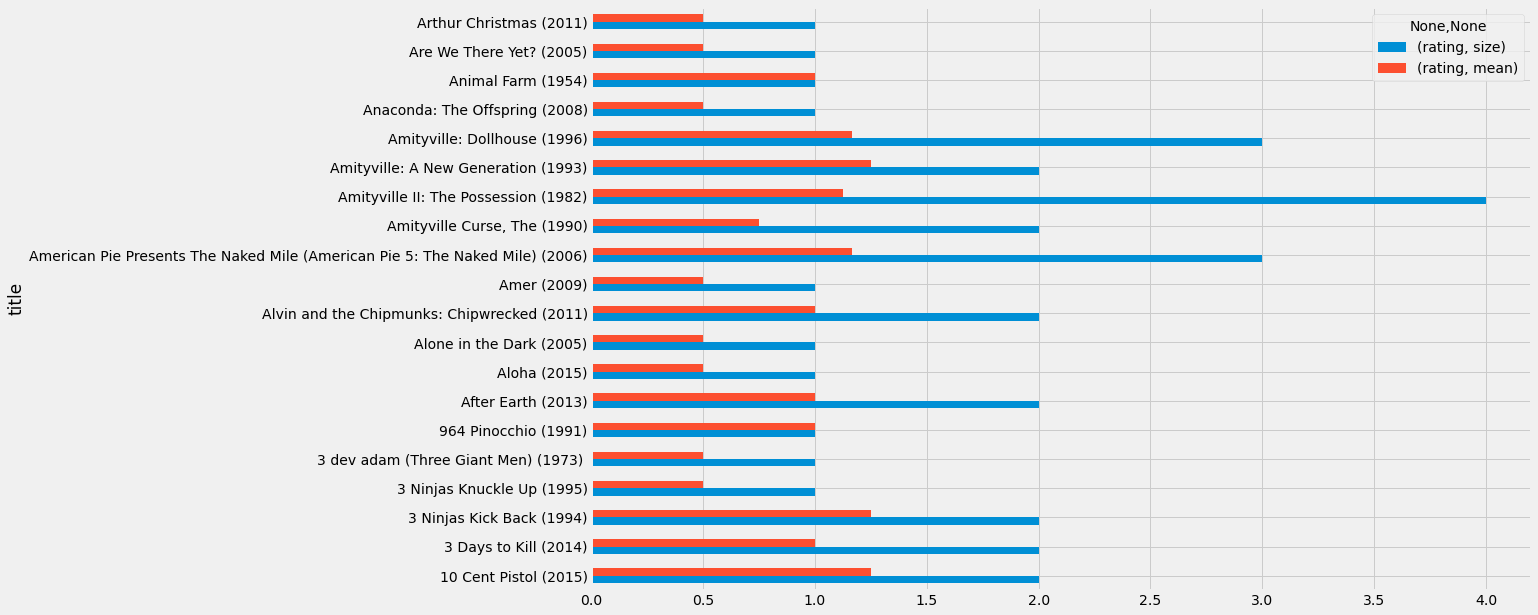

In [29]:
low_rated_movies.head(20).plot(kind='barh', figsize=(15,10));

In [30]:
low_rated_movies.head(10)

rating      
                                              size  mean
title                                                   
10 Cent Pistol (2015)                            2  1.25
3 Days to Kill (2014)                            2  1.00
3 Ninjas Kick Back (1994)                        2  1.25
3 Ninjas Knuckle Up (1995)                       1  0.50
3 dev adam (Three Giant Men) (1973)              1  0.50
964 Pinocchio (1991)                             1  1.00
After Earth (2013)                               2  1.00
Aloha (2015)                                     1  0.50
Alone in the Dark (2005)                         1  0.50
Alvin and the Chipmunks: Chipwrecked (2011)      2  1.00

##### SINCE WE NEED TO RECOMMEND MOVIES TO USERS CONSIDERING THEIR POST REVIEW RATINGS, COLLABORATIVE FILTERING" TECHNIQUE WAS IMPLEMENTED FOR THIS PROBLEM STATEMENT

# Implementation of User-Item Filtering


ITEM based collaborative filtering look for items that are similar to the articles that user has already rated and recommend most similar articles

### Data Merging

In [31]:
df_movies_ratings=pd.merge(df_movies, df_ratings)
df_movies_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


#### we need to build a similarity matrix.
There are 3 distance similarity metrics that are usually used in collaborative filtering:

+ Jaccard Similarity
+ Cosine Similarity
+ Pearson Similarity

### Pivot table function to create user - item matrix

In [32]:
ratings_matrix_users = df_movies_ratings.pivot_table(index=['userId'],columns=['title'],values='rating').reset_index(drop=True)

In [33]:
ratings_matrix_users

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]Â² (2009),[REC]Â³ 3 GÃ©nesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),Â¡Three Amigos! (1986),Ã nous la libertÃ© (Freedom for Us) (1931)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


user_id number 609, for example, did watch the movie '71 (2014)' and gave 4.0 rating, but did not watch 'Hellboy: The Seeds of Creation (2004)' and so on

In [34]:
# filling NaN with 0
ratings_matrix_users.fillna( 0, inplace = True )

# using Cosine 

In [35]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_users, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity)
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


###### """Here now we have similarity of users in colums with respective users in row. So if we find maximum value in a column we will get the user with highest similarity. So now we can have a pair of users which are similar"""

In [36]:
ratings_matrix_users.idxmax(axis=1)

0      265
1      365
2      312
3      390
4      469
      ... 
605    473
606    569
607    479
608    339
609    248
Length: 610, dtype: int64

In [37]:
ratings_matrix_users.idxmax(axis=1).sample( 10, random_state = 10 )

547     76
241    467
277    337
348    454
218    238
407    278
352     45
97     600
381     20
607    479
dtype: int64

# Converting into dataframe

In [38]:
similar_user_series = ratings_matrix_users.idxmax(axis=1)
df_similar_user = similar_user_series.to_frame()

In [39]:
df_similar_user.columns=['similarUser']

"""Below function takes id of the user to whom we have to recommend movies. On basis of that, we find the user which is similar to that user and then filter the movies which are highly rated by the user to recommend them to given user"""

In [40]:
def getRecommendedMoviesAsperUserSimilarity(userId):
    """
    
     Recommending movies which user hasn't watched as per User Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    
    """
    # Getting movies seen by user
    user2Movies= df_ratings[df_ratings['userId']== userId]['movieId']
    # finding similar users
    sim_user=df_similar_user.iloc[user_id].values[0]
    # empty dataframe
    df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
    # find movies users not seen
    for movieId in df_ratings[df_ratings['userId']== sim_user]['movieId']:
        if movieId not in user2Movies:
            df_new= df_movies_ratings[(df_movies_ratings.userId==sim_user) & (df_movies_ratings.movieId==movieId)]
            df_recommended=pd.concat([df_recommended,df_new])
    # sorting best rated movies users not seen yet
    best10_df  = df_recommended.sort_values(by='rating', ascending=True)[0:10]
    return best10_df[['title']]

# FOR USER_ID  50 BEST RECOMMENDED


In [41]:
user_id = 50
recommend_movies = getRecommendedMoviesAsperUserSimilarity(user_id)
recommend_movies.reset_index(drop=True, inplace=True)
print(f"Next best recommended Movies for USER_ID {[user_id]} are:\n\n",recommend_movies)

Next best recommended Movies for USER_ID [50] are:

                                                title
0                                       X-Men (2000)
1             Star Trek V: The Final Frontier (1989)
2                                      Grease (1978)
3                                     Top Gun (1986)
4                                   Liar Liar (1997)
5             I Know What You Did Last Summer (1997)
6                                  Armageddon (1998)
7  Nightmare on Elm Street 5: The Dream Child, A ...
8                         Little Mermaid, The (1989)
9                                  Jack Frost (1998)


# FOR USER_ID  101 BEST RECOMMENDED


In [42]:
user_id = 101
recommend_movies = getRecommendedMoviesAsperUserSimilarity(user_id)
print(f"Next best recommended Movies for USER_ID {[user_id]} are:\n\n",recommend_movies)

Next best recommended Movies for USER_ID [101] are:

                                                    title
84214                        Bridge to Terabithia (2007)
94843                                       Dredd (2012)
37505  Nightmare on Elm Street 3: Dream Warriors, A (...
81562                                   King Kong (2005)
86471  Sweeney Todd: The Demon Barber of Fleet Street...
71278                                        Hulk (2003)
66630                                  Spider-Man (2002)
97536                              Predestination (2014)
96532                                 Snowpiercer (2013)
93803                            The Hunger Games (2012)


# FOR USER_ID  72 BEST RECOMMENDED

In [43]:
user_id = 72
recommend_movies = getRecommendedMoviesAsperUserSimilarity(user_id)
print(f"Next best recommended Movies for USER_ID {[user_id]} are:\n\n",recommend_movies)

Next best recommended Movies for USER_ID [72] are:

                                          title
100627                             Coco (2017)
100582                Blade Runner 2049 (2017)
86928                  Dark Knight, The (2008)
13617                    Mrs. Doubtfire (1993)
100206     Rogue One: A Star Wars Story (2016)
100107                          Arrival (2016)
96269   The Hunger Games: Catching Fire (2013)
93781                  The Hunger Games (2012)
80059                     Batman Begins (2005)
666                           GoldenEye (1995)


# FOR USER_ID  234 BEST RECOMMENDED


In [44]:
user_id = 234
recommend_movies = getRecommendedMoviesAsperUserSimilarity(user_id)
print(f"Next best recommended Movies for USER_ID {[user_id]} are:\n\n",recommend_movies)

Next best recommended Movies for USER_ID [234] are:

                                             title
11326                            True Lies (1994)
4308                        Batman Forever (1995)
17639            James and the Giant Peach (1996)
16052                               Batman (1989)
9060                Star Trek: Generations (1994)
9727              Clear and Present Danger (1994)
15885                   Dances with Wolves (1990)
12619                        Fugitive, The (1993)
10040                         Forrest Gump (1994)
22708  Willy Wonka & the Chocolate Factory (1971)


In [45]:
pickle.dump(ratings_matrix_users, open('ratings_matrix_users.pkl', 'wb'))
pickle.dump(df_similar_user, open('df_similar_user.pkl', 'wb'))
pickle.dump(df_movies, open('df_movies.pkl', 'wb'))
pickle.dump(df_ratings, open('df_ratings.pkl', 'wb'))
pickle.dump(df_movies_ratings, open('df_movies_ratings.pkl', 'wb'))